<a href="https://colab.research.google.com/github/mralamdari/Computer-Vision-Projects/blob/main/Flowers_Recognition's_optimal_approach_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Hello 👋
####This repository will give you a simple approach (but an effective one) to code in PyTorch that can be used recursively for any other problems in Machine Learning/Deep Learning Field.


#####Unfortunately, the Ram crushes in the Colab, so I can't train it with PyTorch; if you have more ram, feel free to run this code, but if you don't have a powerful system to run it, you can run this code in [My Kaggle Notebook](https://www.kaggle.com/code/mralamdari/flowers-recognition-s-optimal-approach-PyTorch), there are more models with trainning results in this notebook and you can easily edit and run it.
#####You can get more details on this project and learn about object recognition on my article on medium; [How to do Object Recognition with PyTorch the Easiest way](https://medium.com/@mr.alamdari/uagehow-to-do-object-recognition-with-pytorch-the-easiest-way-d0a2750f5fe7)

If you are interested in this project and want to learn it by another deep learning api like TensorFlow(keras), feel free to visit my code in [Github](https://github.com/mralamdari/Computer-Vision-Projects/blob/main/Object_Recognition/Flowers_Recognition's_optimal_approach_TensorFlow.ipynb) or [Kaggle](https://www.kaggle.com/code/mralamdari/flowers-recognition-s-optimal-approach-tensorflow); if you are seeking for more information, you can visit my article on medium; [How to do Object Recognition with TensorFlow(Keras) the Easiest way](https://medium.com/@mr.alamdari/imagehow-to-do-object-recognition-with-tensorflow-keras-the-easiest-way-23c7ab9604c7)


# 1.Import Essential Libraris


In [ ]:
import os
import copy
import time
import torch
import warnings
import matplotlib
import torchvision
import pandas as pd
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics, preprocessing

In [ ]:
warnings.filterwarnings('ignore')
warnings.filterwarnings('always')

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive'
!kaggle datasets download -d alxmamaev/flowers-recognition
!unzip \*.zip && rm *.zip

#2. Data
The Dataset in this project contains 4242 images of flowers; the data collection is based on the data Flickr, Google Images, and Yandex images, and it is used to recognize plants from the photo. There are five kinds of flowers: daisy, dandelion, rose, sunflower, and tulip, and each class has about 800 pictures of different sizes but not high resolutions. You can access the dataset here.

In PyTorch, you can readily do DataAugmentation and grow your dataset's size; since Neural Networks need more data to train, it will enhance the model's performance.

### Transformer

In [ ]:
path = '/content/flowers'

In [ ]:
mean = (0.4124234616756439, 0.3674212694168091, 0.2578217089176178)
std = (0.3268945515155792, 0.29282665252685547, 0.29053378105163574)

In [ ]:
transformer = {
    'original': torchvision.transforms.Compose([
                                               torchvision.transforms.Resize((220, 220)),
                                               torchvision.transforms.ToTensor(),
                                               torchvision.transforms.Normalize(mean, std)
    ]),
    'dataset1': torchvision.transforms.Compose([
                                               torchvision.transforms.Resize((220, 220)),
                                               torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                               torchvision.transforms.RandomRotation(5),
                                               torchvision.transforms.RandomAffine(degrees=11, translate=(0.1, 0.1), scale=(0.8, 0.8)),
                                               torchvision.transforms.ToTensor(),
                                               torchvision.transforms.Normalize(mean, std)
    ]),
    'dataset2': torchvision.transforms.Compose([
                                               torchvision.transforms.Resize((220, 220)),
                                               torchvision.transforms.RandomHorizontalFlip(),
                                               torchvision.transforms.RandomRotation(10),
                                               torchvision.transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
                                               torchvision.transforms.ToTensor(),
                                               torchvision.transforms.RandomErasing(inplace=True, scale=(0.01,  0.23)),
                                               torchvision.transforms.Normalize(mean, std)
    ]),
    'dataset3': torchvision.transforms.Compose([
                                               torchvision.transforms.Resize((220, 220)),
                                               torchvision.transforms.RandomHorizontalFlip(p=0.5),
                                               torchvision.transforms.RandomRotation(15),
                                               torchvision.transforms.RandomAffine(degrees=11, translate=(0.1, 0.1), scale=(0.8, 0.8)),
                                               torchvision.transforms.ToTensor(),
                                               torchvision.transforms.Normalize(mean, std)
    ]),
}

### Train/Test/Val Split

In [ ]:
#all dataset ==> train&val + test
original = torchvision.datasets.ImageFolder(path, transform=transformer['original'])

In [ ]:
train_val, test = model_selection.train_test_split(original, test_size=0.2, random_state=32, shuffle=True)

In [ ]:
# train_val  ==> train + val + dataset1 + dataset2 + dataset3
train_val_ds = torch.utils.data.ConcatDataset([train_val,
                                torchvision.datasets.ImageFolder(path, transform=transformer['dataset1']),
                                torchvision.datasets.ImageFolder(path, transform=transformer['dataset2']),
                                torchvision.datasets.ImageFolder(path, transform=transformer['dataset3'])])


In [ ]:
train, val = model_selection.train_test_split(train_val_ds, test_size=0.1, random_state=32, shuffle=True)

###Notice 1:
since there isn't enough ram to support all dataset1 + dataset2 + dataset3, I will only use train_val and test set as my train / val datasets.

In [ ]:
train = train_val
val = test

###Notice 2:
We need more data so we ignore test data for now and focus only on train/val data

In [ ]:
# train_val  ==> Original + dataset1 + dataset2 + dataset3
train_val_ds = torch.utils.data.ConcatDataset([
                                torchvision.datasets.ImageFolder(path, transform=transformer['original']),
                                # torchvision.datasets.ImageFolder(path, transform=transformer['dataset1']),
                                torchvision.datasets.ImageFolder(path, transform=transformer['dataset2']),
                                torchvision.datasets.ImageFolder(path, transform=transformer['dataset3'])])

train, val = model_selection.train_test_split(train_val_ds, test_size=0.1, random_state=32, shuffle=True)

batch_size = 32
data_loaders = {
    'train': torch.utils.data.DataLoader(train, batch_size=batch_size, pin_memory=True, num_workers=2),
    'val': torch.utils.data.DataLoader(val, batch_size=batch_size, pin_memory=True, num_workers=2),
}

In [ ]:
len(train), len(val)

(11655, 1296)

### Data Loader

In [ ]:
batch_size=32
data_loaders = {
    'train': torch.utils.data.DataLoader(train, batch_size=batch_size, num_workers=2, pin_memory=True),
    'val': torch.utils.data.DataLoader(val, batch_size=batch_size, num_workers=2, pin_memory=True),
    'test': torch.utils.data.DataLoader(test, batch_size=batch_size, num_workers=2, pin_memory=True)
}

dataset_sizes = {
    'train': len(train),
    'val': len(val),
    'test': len(test)
}

In [ ]:
dataset_sizes

{'test': 864, 'train': 14763, 'val': 1641}

#### How ImBalance is ourdaset

In [ ]:
dic = {}
for cls in original.classes:
  dic[cls] = len(os.listdir(f'{path}/{cls}'))

samplesize = pd.DataFrame(dic, index=[0])
samplesize

daisy  dandelion  rose  sunflower  tulip
0    764       1052   784        733    984

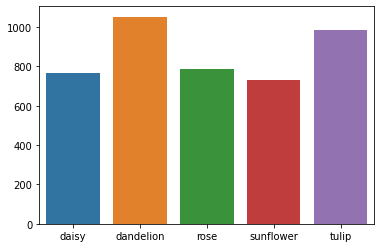

In [ ]:
sns.barplot(data=samplesize)

# 3.Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0876) tensor(0.8731)


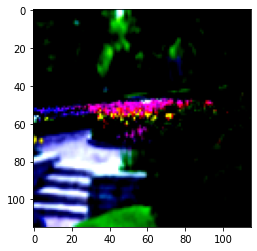

In [ ]:
z, _ = next(iter(data_loaders['test']))
print(z.mean(), z.std())
img_norm = z[0].permute(1, 2, 0).numpy()
plt.imshow(img_norm)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.1441) tensor(0.9451)


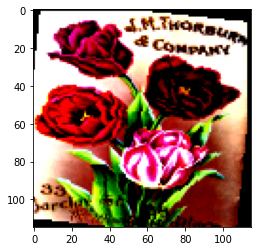

In [ ]:
z, _ = next(iter(data_loaders['val']))
print(z.mean(), z.std())
img_norm = z[0].permute(1, 2, 0).numpy()
plt.imshow(img_norm)

In [ ]:
def plot_imgs(imgs, nrows=5, ncols=5):
  fig, ax = plt.subplots(nrows, ncols, figsize=(nrows*5, ncols*3))
  index = 0
  for row in range(nrows):
    for col in range(ncols):
      img = matplotlib.image.imread(imgs[index][0])
      ax[row][col].imshow(img)
      ax[row][col].axis('off')
      ax[row][col].set_title(imgs[index][1], fontsize=15)
      index += 1

In [ ]:
def rand_imgs(original, img_folder=path, count=25):
  rand_imgs = []
  categories = original.classes
  for cat in categories:
    folder_path = f"{img_folder}/{cat}"
    imgs_list = os.listdir(folder_path)
    selected_imgs = np.random.choice(imgs_list, count//len(categories))
    rand_imgs.extend([(f'{folder_path}/{img_path}', cat) for img_path in selected_imgs])
  np.random.shuffle(rand_imgs)
  return rand_imgs

In [ ]:
my_imgs = rand_imgs(original, path, 15)

In [ ]:
plot_imgs(my_imgs, 5, 3)

In [ ]:
def plot_batch(data_loader):
  for imgs, labels in data_loader:
    fig, ax = plt.subplots(figsize=(25, 25))
    ax.imshow(torchvision.utils.make_grid(imgs[:60], nrow=10).permute(1, 2, 0))
    ax.set_title('Augmented Images')
    break

In [ ]:
plot_batch(data_loaders['train'])

In [ ]:
plot_batch(data_loaders['val'])

In [ ]:
plot_batch(data_loaders['test'])

# 4.Loss

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds)), preds

In [ ]:
path2weights = '/content/models/'
os.makedirs(path2weights, exist_ok=True)

In [ ]:
def get_lr(opt):
  for param_group in opt.param_groups:
    return param_group['lr']

In [ ]:
def loss_epoch(model, data_loader, criterion, optimizer, scheduler, sanity_check, phase):
  epoch_loss = 0.0
  epoch_acc = 0.0

  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()

    with torch.set_grad_enabled(phase=='train'):
      output = model(inputs)
      _, pred = torch.max(output, 1)
      loss = criterion(output, labels)

    epoch_loss += loss.cpu().detach().numpy().item() / len(labels)
    epoch_acc += pred.eq(labels.view_as(pred)).sum().item() / len(labels)

    if phase == 'train':
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      scheduler.step(epoch_acc) 

    if sanity_check:
      break
  
  return epoch_loss, epoch_acc

In [ ]:
def train_val(model, params, grad_requires_param=False, trainable_layers=0):
  
  model_name = params['model_name']
  num_epochs = params['epochs']
  optimizer = params['optimizer']
  criterion = params['criterion']
  scheduler = params['scheduler']
  data_loaders = params['data_loaders']
  path2weights = params['path2weights']
  sanity_check = params['sanity_check']
    
  #A dictionary to save Loss's history and accuracy's history
  loss_history = {'train': [], 'val':[]}
  accuracy_history = {'train': [], 'val':[]}
  lr = [get_lr(optimizer)]
    
  #Unfreeze the model, with trainable_layers count
  if grad_requires_param:
      print(f"Unfreezing model's {trainable_layers} Last Layers")
      model_params_len = len(list(model.parameters()))
      for i, param in enumerate(model.parameters()):
        if model_params_len - i > trainable_layers:
          param.grad_requires == grad_requires_param
  
  model.to(device) 
  best_accuracy = 0.0
  best_loss = float('inf')
  best_model = copy.deepcopy(model.state_dict())

  for epoch in range(num_epochs):
    
    for phase in ['train', 'val']:
      start = time.time()  
      if phase == 'train':
        model.train()
      else:
        model.eval()

      epoch_loss, epoch_acc = loss_epoch(model, data_loaders[phase], criterion, optimizer, scheduler, sanity_check, phase)
      my_epoch_loss = epoch_loss / len(data_loaders[phase])
      my_epoch_acc = epoch_acc / len(data_loaders[phase])
  
      loss_history[phase].append(my_epoch_loss)
      accuracy_history[phase].append(my_epoch_acc)
        
      if phase == 'train':  
        lr.append(get_lr(optimizer))
        
        
      if phase == 'val' and epoch_acc > best_accuracy:
        best_accuracy = epoch_acc
        best_model = copy.deepcopy(model.state_dict())
        torch.save(best_model, f'{model_name}_wts.h5')


      during = time.time() - start
      print(f'{phase.upper()} ===> Time: {during//60}m {during%60:.2f}s')
    
    print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {loss_history['train'][-1]:.4f}, Train Accuracy: %{accuracy_history['train'][-1]:.3f}, Val Loss: {loss_history['val'][-1]:.4f}, Val Accuracy: %{accuracy_history['val'][-1]:.4f}")
    print('===='*10)

        
  model.load_state_dict(best_model)        
  return model, loss_history, accuracy_history

In [ ]:
def plot_history(hist, loss='True'):
  title = 'loss' if loss else 'accuracy'
  plt.plot(hist[f'train'])
  plt.plot(hist[f'val'])
  plt.title(f'Model {title}')
  plt.ylabel(f'{title}')
  plt.xlabel('Epochs')
  plt.legend(['train', 'test'])
  plt.show()

# 5.Models

##### sanity_check is used in the model's train function to determin if we want to train the model by all the dataset or just one batch from a dataset is enough for our training because we only want to check if the model is working correctly or not?
#### sanity_check == False   ====> Use the whole dataset
#### sanity_check == True   ====> Use only one batch of the dataset

In [ ]:
sanity_check = False

### VGG16

In [ ]:
vgg16 = torchvision.models.vgg16(pretrained=True)

for param in vgg16.parameters():
    param.grad_requires = False

vgg16.classifier[6] = torch.nn.Linear(in_features=vgg16.classifier[6].in_features,
                                  out_features=len(original.classes), 
                                  bias=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
optimizer_vgg16 = torch.optim.Adam(vgg16.classifier.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)
scheduler_vgg16 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_vgg16, mode='max', patience=3, verbose=1)
epochs = 50
params_vgg16 = {
    'epochs': epochs,
    'model_name': 'vgg16',
    'data_loaders': data_loaders,
    'criterion': torch.nn.CrossEntropyLoss(),
    'optimizer': optimizer_vgg16,
    'scheduler': scheduler_vgg16,
    'path2weights': path2weights,
    'sanity_check': sanity_check
}

### VGG19

In [ ]:
vgg19_bn = torchvision.models.vgg19_bn(weights=torchvision.models.VGG19_BN_Weights.IMAGENET1K_V1)

for param in vgg19_bn.parameters():
    param.grad_requires = False

vgg19_bn.classifier[6] = torch.nn.Linear(in_features=vgg19_bn.classifier[6].in_features,
                                  out_features=len(original.classes), 
                                  bias=True)

In [ ]:
optimizer_vgg19_bn = torch.optim.Adam(vgg19_bn.classifier.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)
scheduler_vgg19_bn= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_vgg19_bn, mode='max', patience=3, verbose=1)
epochs = 30
vgg19_bn_params = {
    'epochs': epochs,
    'model_name': 'vgg19_bn',
    'data_loaders': data_loaders,
    'criterion': torch.nn.CrossEntropyLoss(),
    'optimizer': optimizer_vgg19_bn,
    'scheduler': scheduler_vgg19_bn,
    'path2weights': path2weights,
    'sanity_check': sanity_check
}

### ResNet50

In [ ]:
resnet50 = torchvision.models.resnet50(torchvision.models.ResNet50_Weights.IMAGENET1K_V1)

for param in resnet50.parameters():
    param.grad_requires = False

resnet50.fc = torch.nn.Linear(in_features=resnet50.fc.in_features,
                                  out_features=len(original.classes), 
                                  bias=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "


In [ ]:
optimizer_resnet50 = torch.optim.Adam(resnet50.fc.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)
scheduler_resnet50 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_resnet50, mode='max', patience=3, verbose=1)
epochs = 30
resnet50_params = {
    'epochs': epochs,
    'model_name': 'resnet50',
    'data_loaders': data_loaders,
    'criterion': torch.nn.CrossEntropyLoss(),
    'optimizer': optimizer_resnet50,
    'scheduler': scheduler_resnet50,
    'path2weights': path2weights,
    'sanity_check': sanity_check
}

### EfficientNet B2

In [ ]:
efficientnetb2 = torchvision.models.efficientnet_b2(pretrained=True)

for param in efficientnetb2.parameters():
    param.grad_requires = False

efficientnetb2.classifier = torch.nn.Linear(in_features=efficientnetb2.classifier[1].in_features,
                                  out_features=len(original.classes), 
                                  bias=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth


  0%|          | 0.00/35.2M [00:00<?, ?B/s]

In [ ]:
optimizer_efficientnetb2 = torch.optim.Adam(efficientnetb2.classifier.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)
scheduler_efficientnetb2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_efficientnetb2, mode='max', patience=3, verbose=1)
epochs = 30
efficientnetb2_params = {
    'epochs': epochs,
    'model_name': 'efficientnetb2',
    'data_loaders': data_loaders,
    'criterion': torch.nn.CrossEntropyLoss(),
    'optimizer': optimizer_efficientnetb2,
    'scheduler': scheduler_efficientnetb2,
    'path2weights': path2weights,
    'sanity_check': sanity_check
}

### 6.Training

#### vgg16

In [ ]:
model, loss_history, accuracy_history = train_val(vgg16, params_vgg16, grad_requires_param=False, trainable_layers=0)

TRAIN ===> Time: 0.0m 24.32s
VAL ===> Time: 0.0m 6.14s
Epoch: 1/50, Train Loss: 3.8799, Train Accuracy: %62.418, Val Loss: 0.6957, Val Accuracy: %20.6562
TRAIN ===> Time: 0.0m 15.49s
VAL ===> Time: 0.0m 6.06s
Epoch: 2/50, Train Loss: 2.4661, Train Accuracy: %83.640, Val Loss: 0.5356, Val Accuracy: %21.8438
TRAIN ===> Time: 0.0m 15.61s
VAL ===> Time: 0.0m 6.18s
Epoch: 3/50, Train Loss: 2.0494, Train Accuracy: %87.206, Val Loss: 0.4698, Val Accuracy: %22.4375
TRAIN ===> Time: 0.0m 15.71s
VAL ===> Time: 0.0m 6.14s
Epoch: 4/50, Train Loss: 1.8495, Train Accuracy: %88.487, Val Loss: 0.4302, Val Accuracy: %22.5312
TRAIN ===> Time: 0.0m 15.74s
Epoch 00005: reducing learning rate of group 0 to 1.0000e-05.
VAL ===> Time: 0.0m 6.21s
Epoch: 5/50, Train Loss: 1.7036, Train Accuracy: %89.990, Val Loss: 0.4034, Val Accuracy: %22.7812
TRAIN ===> Time: 0.0m 15.84s
VAL ===> Time: 0.0m 6.25s
Epoch: 6/50, Train Loss: 1.6305, Train Accuracy: %91.143, Val Loss: 0.4001, Val Accuracy: %22.7500
TRAIN ===> Tim

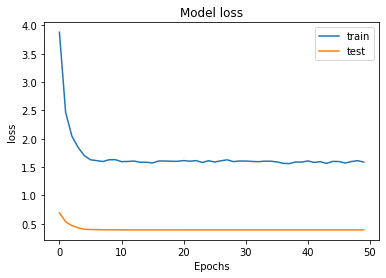

In [ ]:
plot_history(loss_history, loss='True')

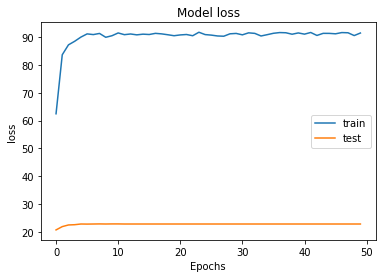

In [ ]:
plot_history(accuracy_history, loss='False')

#### vgg19

In [ ]:
model, loss_history, accuracy_history = train_val(vgg19_bn, vgg19_bn_params, grad_requires_param=False, trainable_layers=0)

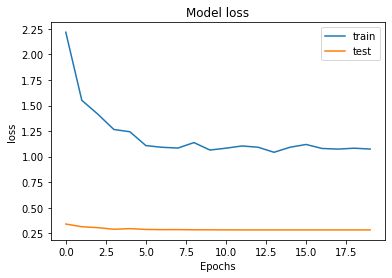

In [ ]:
plot_history(loss_history, loss='True')

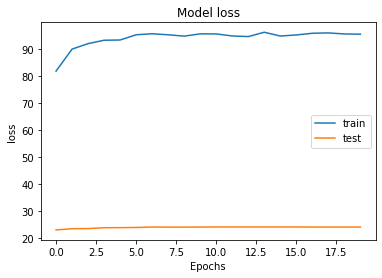

In [ ]:
plot_history(accuracy_history, loss='False')

#### ResNet50

In [ ]:
model, loss_history, accuracy_history = train_val(resnet50, resnet50_params, grad_requires_param=False, trainable_layers=0)

TRAIN ===> Time: 0.0m 11.25s
VAL ===> Time: 0.0m 2.91s
Epoch: 1/30, Train Loss: 4.4410, Train Accuracy: %59.703, Val Loss: 0.8751, Val Accuracy: %19.7500
TRAIN ===> Time: 0.0m 10.81s
VAL ===> Time: 0.0m 2.91s
Epoch: 2/30, Train Loss: 3.0982, Train Accuracy: %84.675, Val Loss: 0.6542, Val Accuracy: %22.3125
TRAIN ===> Time: 0.0m 10.89s
VAL ===> Time: 0.0m 2.91s
Epoch: 3/30, Train Loss: 2.4755, Train Accuracy: %89.365, Val Loss: 0.5431, Val Accuracy: %22.7500
TRAIN ===> Time: 0.0m 10.98s
VAL ===> Time: 0.0m 2.92s
Epoch: 4/30, Train Loss: 2.1282, Train Accuracy: %91.178, Val Loss: 0.4774, Val Accuracy: %22.9688
TRAIN ===> Time: 0.0m 11.00s
Epoch 00005: reducing learning rate of group 0 to 1.0000e-05.
VAL ===> Time: 0.0m 2.97s
Epoch: 5/30, Train Loss: 1.9054, Train Accuracy: %92.397, Val Loss: 0.4340, Val Accuracy: %23.2500
TRAIN ===> Time: 0.0m 11.09s
VAL ===> Time: 0.0m 3.00s
Epoch: 6/30, Train Loss: 1.7970, Train Accuracy: %93.303, Val Loss: 0.4218, Val Accuracy: %23.4062
TRAIN ===> Tim

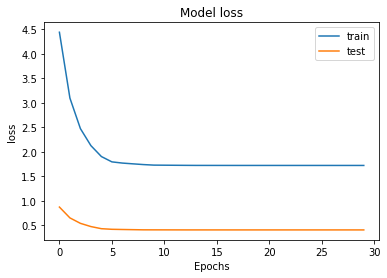

In [ ]:
plot_history(loss_history, loss='True')

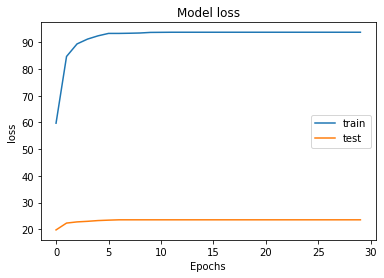

In [ ]:
plot_history(accuracy_history, loss='False')

#### EfficentNet B2

In [ ]:
model, loss_history, accuracy_history = train_val(efficientnetb2, efficientnetb2_params, grad_requires_param=False, trainable_layers=0)

TRAIN ===> Time: 0.0m 7.79s
VAL ===> Time: 0.0m 1.99s
Epoch: 1/30, Train Loss: 4.7851, Train Accuracy: %56.324, Val Loss: 1.0655, Val Accuracy: %19.4062
TRAIN ===> Time: 0.0m 7.46s
VAL ===> Time: 0.0m 1.97s
Epoch: 2/30, Train Loss: 3.8505, Train Accuracy: %80.196, Val Loss: 0.8797, Val Accuracy: %21.6250
TRAIN ===> Time: 0.0m 7.50s
VAL ===> Time: 0.0m 1.98s
Epoch: 3/30, Train Loss: 3.2400, Train Accuracy: %86.953, Val Loss: 0.7569, Val Accuracy: %22.4375
TRAIN ===> Time: 0.0m 7.51s
VAL ===> Time: 0.0m 1.98s
Epoch: 4/30, Train Loss: 2.8457, Train Accuracy: %87.543, Val Loss: 0.6704, Val Accuracy: %22.8125
TRAIN ===> Time: 0.0m 7.54s
Epoch 00005: reducing learning rate of group 0 to 1.0000e-05.
VAL ===> Time: 0.0m 2.04s
Epoch: 5/30, Train Loss: 2.5556, Train Accuracy: %89.293, Val Loss: 0.6090, Val Accuracy: %23.0000
TRAIN ===> Time: 0.0m 7.56s
VAL ===> Time: 0.0m 2.03s
Epoch: 6/30, Train Loss: 2.4133, Train Accuracy: %90.227, Val Loss: 0.6011, Val Accuracy: %23.0000
TRAIN ===> Time: 0.0

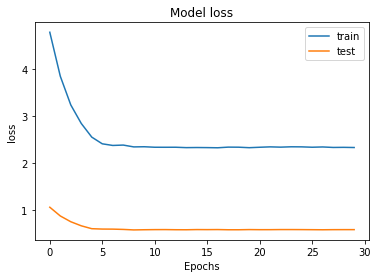

In [ ]:
plot_history(loss_history, loss='True')

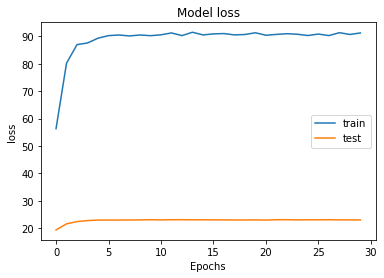

In [ ]:
plot_history(accuracy_history, loss='False')

### 7.Fine-Tuning